In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

In [10]:
data = pd.read_csv('kl.csv', encoding = "ISO-8859-1")

# 1. EDA (Исследовательский анализ данных)

### Общая информация о данных:

In [11]:
# Удаляем столбцы, не нужные для анализа
columns_to_drop = ['Unnamed: 0', 'ID', 'Name', 'Photo', 'Flag', 'Club Logo', 'Nationality', 
                   'Value', 'Wage', 'Special', 'Release Clause', 'Club', 'Loaned From', 
                   'Contract Valid Until', 'Joined']
data_cleaned = data.drop(columns=columns_to_drop).dropna()

In [12]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16121 entries, 0 to 18206
Data columns (total 74 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       16121 non-null  float64
 1   Overall                   16121 non-null  float64
 2   Potential                 16121 non-null  int64  
 3   Preferred Foot            16121 non-null  object 
 4   International Reputation  16121 non-null  float64
 5   Weak Foot                 16121 non-null  float64
 6   Skill Moves               16121 non-null  float64
 7   Work Rate                 16121 non-null  object 
 8   Body Type                 16121 non-null  object 
 9   Real Face                 16121 non-null  object 
 10  Position                  16121 non-null  object 
 11  Jersey Number             16121 non-null  float64
 12  Height                    16121 non-null  object 
 13  Weight                    16121 non-null  object 
 14  LS         

In [13]:
# Кодирование категориальных признаков
categorical_cols = ['Preferred Foot', 'Work Rate', 'Body Type', 'Real Face', 'Position', 'Height', 'Weight']
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col in categorical_cols:
    data_cleaned[col] = label_encoders[col].fit_transform(data_cleaned[col])

In [18]:
# Преобразуем значения типа '88+2' в числовой формат
def convert_position_value(value):
    if isinstance(value, str) and '+' in value:
        base, addition = map(int, re.findall(r'\d+', value))
        return base + addition
    try:
        return float(value)
    except ValueError:
        return None

# Применяем преобразование для столбцов с позициями
position_cols = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 
                 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 
                 'CB', 'RCB', 'RB']
for col in position_cols:
    data_cleaned[col] = data_cleaned[col].apply(convert_position_value)

### Корреляционный анализ

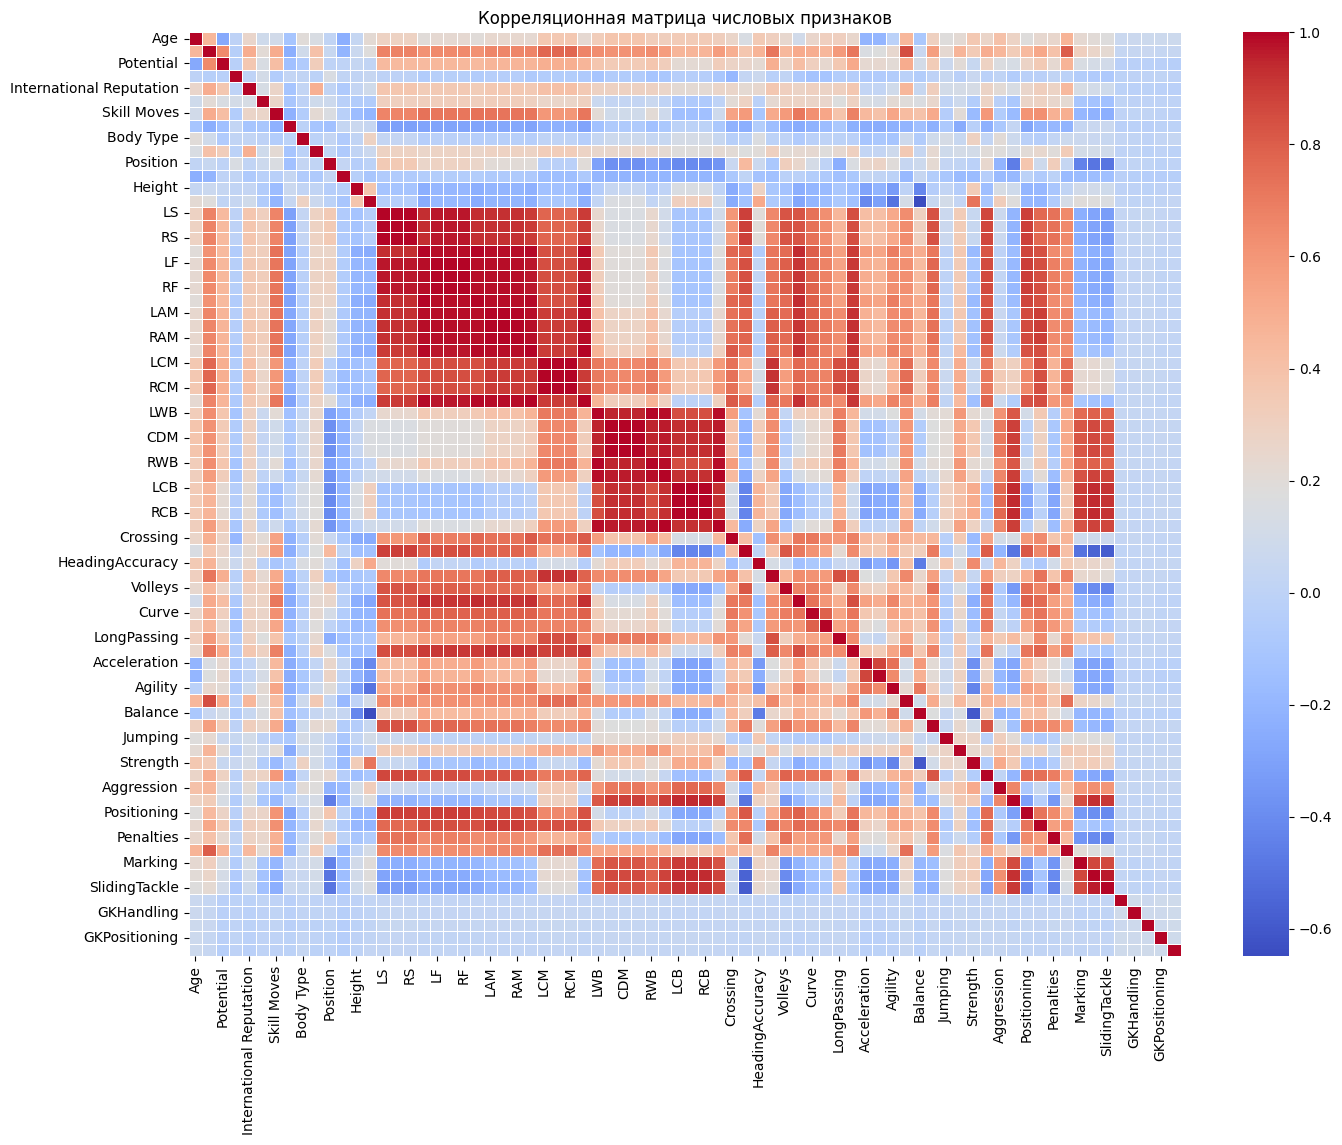

In [46]:
# Рассчитываем корреляционную матрицу для числовых признаков
corr_matrix = data_cleaned.corr()

# Визуализируем корреляционную матрицу
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Корреляционная матрица числовых признаков")
plt.show()

### Вывод

Корреляционный анализ показывает высокую корреляцию между позиционными и защитными признаками, что указывает на избыточность данных. Например, такие признаки, как LS, RS, LAM, RAM, LCM, RCM, CB, RCB, LCB и StandingTackle, SlidingTackle, Interceptions, Marking, сильно коррелируют между собой.

## Стандартизация

In [19]:
# Отделяем признаки и целевую переменную
X = data_cleaned.drop(columns=['Overall'])  # 'Overall' — это наша целевая переменная
y = data_cleaned['Overall']

# Стандартизация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Определение важности признаков

In [21]:
# Обучаем модель RandomForest для оценки важности признаков
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_scaled, y)

# Извлекаем и сортируем важность признаков
importances = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Выводим топ-10 признаков по важности
print(feature_importance.head(10))

      Feature  Importance
52  Reactions    0.653021
1   Potential    0.082038
37        RCB    0.033763
35        LCB    0.032711
36         CB    0.030221
18         CF    0.022136
17         LF    0.021865
19         RF    0.019439
28         RM    0.017611
24         LM    0.014570


### Вывод

В RandomForestRegressor Reactions, Potential, и некоторые позиции игроков, такие как RCB, LCB, и CB, имеют наибольший вес для предсказания Overall. Это указывает на то, что реакция и потенциал игрока, а также его навыки в определенных позициях играют важную роль.

### Уменьшение размерности и визуализация

Снизим размерность с помощью PCA и t-SNE. Эти методы позволят визуализировать данные и понять их структуру.

### PCA

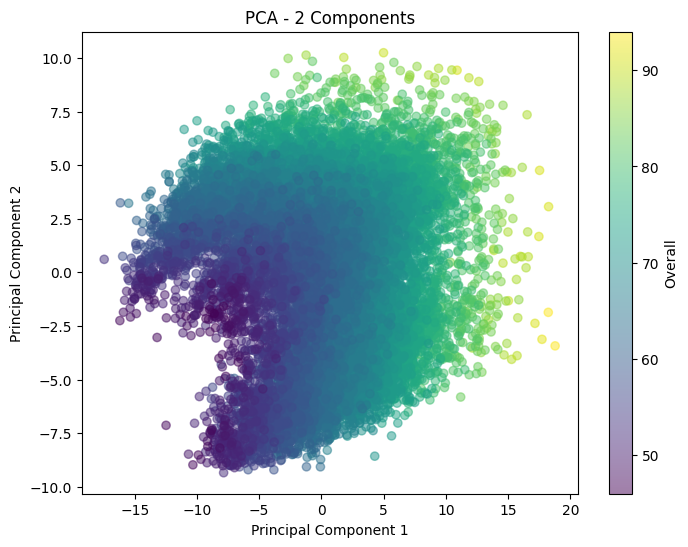

In [25]:
# PCA до 2 компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Визуализация результатов PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.colorbar(label='Overall')
plt.title('PCA - 2 Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### Вклад признаков в компоненты PCA

In [29]:
pca_components = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2'])
top_pc1 = pca_components.T.nlargest(5, 'PC1')  # Топ 5 признаков для первой компоненты
top_pc2 = pca_components.T.nlargest(5, 'PC2')  # Топ 5 признаков для второй компоненты

print("Вклад признаков в первую компоненту PCA:")
print(top_pc1)
print("\nВклад признаков во вторую компоненту PCA:")
print(top_pc2)

Вклад признаков в первую компоненту PCA:
          PC1       PC2
LAM  0.184252 -0.037210
CAM  0.184252 -0.037210
RAM  0.184252 -0.037210
LM   0.183877 -0.026446
RM   0.183877 -0.026446

Вклад признаков во вторую компоненту PCA:
                     PC1       PC2
LCB             0.021485  0.245769
CB              0.021485  0.245769
RCB             0.021485  0.245769
StandingTackle -0.006089  0.238501
Interceptions   0.008546  0.236707


### Вывод

На графике PCA можно увидеть, что игроки распределены по непрерывному градиенту (по оси Overall). Это означает, что PCA помогает выявить некоторые закономерности в данных, но четких кластеров не наблюдается, что характерно для такого рода данных, где значения Overall распределены плавно.

### t-SNE

t-SNE хорошо подходит для нелинейной визуализации данных в двумерном пространстве.

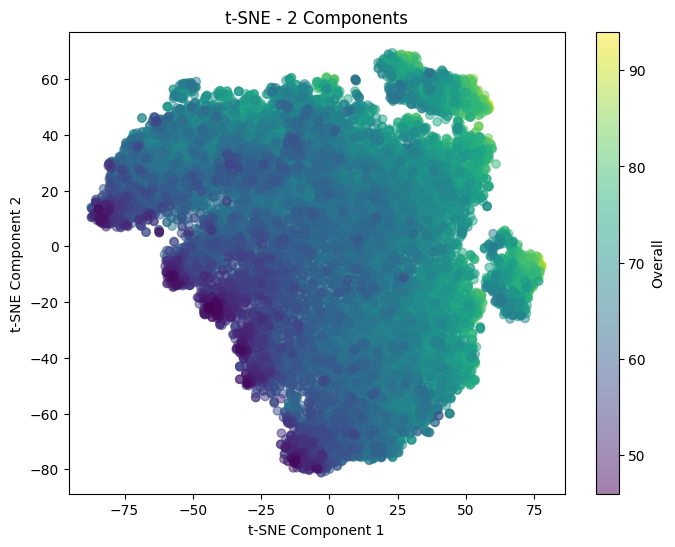

In [28]:
# t-SNE до 2 компонент
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Визуализация результатов t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.colorbar(label='Overall')
plt.title('t-SNE - 2 Components')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

### Вывод

График t-SNE показывает чуть более сложную структуру, но также без четких кластеров. Это говорит о том, что данные не имеют жестко разделенных групп, а скорее представляют собой непрерывное распределение, где игроки различаются по своим характеристикам плавно.

## Проверка распределения целевой переменной (балансировка)

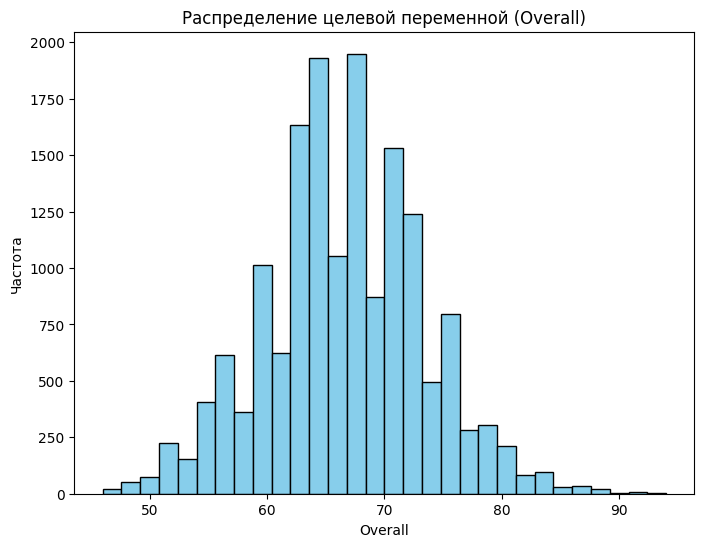

In [37]:
# Визуализируем распределение целевой переменной
plt.figure(figsize=(8, 6))
plt.hist(y, bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение целевой переменной (Overall)')
plt.xlabel('Overall')
plt.ylabel('Частота')
plt.show()

### Вывод

Гистограмма показывает, что целевая переменная Overall имеет примерно нормальное распределение с пиком около значений 65-70. Это значит, что датасет сбалансирован для задачи регрессии.

# Обучение модели

## Шаг 1: Разделение данных на обучающую и тестовую выборки

In [31]:
# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Шаг 2: Feature Selection с использованием важности признаков

In [32]:
# Выбираем топ-20 наиболее важных признаков на основе важности из RandomForest
top_features = feature_importance['Feature'][:20].values  # Топ 20 признаков
X_train_reduced = X_train[:, :20]
X_test_reduced = X_test[:, :20]

## Шаг 3: Обучение и оптимизация моделей

### RandomForestRegressor

In [40]:
# Ограничиваем сетку гиперпараметров
param_dist_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2']
}

# Используем RandomizedSearchCV для ускорения
rf = RandomForestRegressor(random_state=42)
random_search_rf = RandomizedSearchCV(rf, param_dist_rf, cv=5, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1)
random_search_rf.fit(X_train, y_train)

# Лучшая модель
best_rf = random_search_rf.best_estimator_
print("Лучшие параметры для RandomForest:", random_search_rf.best_params_)

Лучшие параметры для RandomForest: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': None}


In [42]:
# Обучаем модель с наилучшими гиперпараметрами
best_rf.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_rf = best_rf.predict(X_test)

# Оценка качества модели
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("MSE для RandomForest с оптимизированными параметрами:", mse_rf)

MSE для RandomForest с оптимизированными параметрами: 0.6674040310077518


### Вывод

MSE для RandomForest с оптимизированными параметрами: 0.6674040310077518

### GradientBoostingRegressor

In [43]:
# Определяем диапазон гиперпараметров для Gradient Boosting
param_dist_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

# Используем RandomizedSearchCV для поиска лучших гиперпараметров
gb = GradientBoostingRegressor(random_state=42)
random_search_gb = RandomizedSearchCV(gb, param_dist_gb, cv=5, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search_gb.fit(X_train, y_train)

# Лучшая модель и оценка на тестовой выборке
best_gb = random_search_gb.best_estimator_
print("Лучшие параметры для GradientBoosting:", random_search_gb.best_params_)

# Предсказания и оценка модели
y_pred_gb = best_gb.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print("MSE для GradientBoosting с оптимизированными параметрами:", mse_gb)

Лучшие параметры для GradientBoosting: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
MSE для GradientBoosting с оптимизированными параметрами: 0.5844558575608819


### Вывод

MSE для GradientBoosting с оптимизированными параметрами: 0.5844558575608819

### KNeighborsRegressor

In [45]:
# Определяем диапазон гиперпараметров для KNeighborsRegressor
param_dist_knn = {
    'n_neighbors': [5, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Расстояние Манхэттена (p=1) и Евклидово расстояние (p=2)
}

# Используем RandomizedSearchCV с сокращенным набором признаков
X_train_reduced = X_train[:, :20]  # Топ 20 важных признаков
X_test_reduced = X_test[:, :20]

knn = KNeighborsRegressor()
random_search_knn = RandomizedSearchCV(knn, param_dist_knn, cv=5, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search_knn.fit(X_train_reduced, y_train)

# Лучшая модель и оценка на тестовой выборке
best_knn = random_search_knn.best_estimator_
print("Лучшие параметры для KNeighbors:", random_search_knn.best_params_)

# Предсказания и оценка модели
y_pred_knn = best_knn.predict(X_test_reduced)
mse_knn = mean_squared_error(y_test, y_pred_knn)
print("MSE для KNeighbors с оптимизированными параметрами:", mse_knn)

Лучшие параметры для KNeighbors: {'weights': 'distance', 'p': 1, 'n_neighbors': 10}
MSE для KNeighbors с оптимизированными параметрами: 5.699828771625196


### Вывод

MSE для KNeighbors с оптимизированными параметрами: 5.699828771625196

### Общий вывод

Итоговые значения MSE для моделей:

 1. GradientBoostingRegressor: MSE = 0.5845
 2. RandomForestRegressor: MSE = 0.6674
 3. KNeighborsRegressor: MSE = 5.

- GradientBoostingRegressor демонстрирует наименьшее значение ошибки (MSE = 0.5845), что делает его лучшим выбором для этой задачи.
-  RandomForestRegressor также показывает неплохие результаты, но уступает Gradient Boosting
-  KNeighborsRegressor имеет значительно более высокую ошибку, что может быть связано с его чувствительностью к размерности данных, даже несмотря на сокращение числа признаков.6998